In [1]:
import os
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

In [2]:
datasetDir = "Micro_Expressions"
classes = os.listdir(datasetDir + "/train")
print("Expression Labels: ",classes)
tfms = tt.Compose([tt.RandomCrop(80, padding=15, padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor()])
dataset1 = ImageFolder(datasetDir+"/train",tfms)
dataset2 = ImageFolder(datasetDir+"/train",transform=ToTensor())
dataset = dataset1+dataset2
dataset.classes = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

Expression Labels:  ['.DS_Store', 'fear', 'surprise', 'sadness', 'neutral', 'happiness', 'anger', 'disgust']


## Splitting of Trianing set

In [3]:
randomSeed = 3 
torch.manual_seed(randomSeed)
valSize = 2000
trainSize = len(dataset)-valSize
trainDS, valDS = random_split(dataset,[trainSize,valSize])

In [4]:
batchSize = 200
trainDL = DataLoader(trainDS,batchSize,shuffle=True,num_workers=4, pin_memory=True)
valDL = DataLoader(valDS,batchSize*2,num_workers=4, pin_memory=True)

In [5]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() 
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {} , train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

## CNN based Model

In [12]:
class ATTModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
    
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            #nn.Dropout2d(p=0.5),
    
            nn.Flatten(),
            nn.Linear(256*10*10, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
            #nn.Softmax(-1)
        
    def forward(self, xb):
        return self.network(xb)

In [13]:
# Model structure
model = ATTModel()
print(model)

ATTModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=25600, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1

In [14]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device): 
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
train_dl = DeviceDataLoader(trainDL, device)
val_dl = DeviceDataLoader(valDL, device)
to_device(model, device);

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model Training

In [16]:
model = to_device(ATTModel(), device)
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 0 , train_loss: 1.8936, val_loss: 1.8075, val_acc: 0.2670
Epoch 1 , train_loss: 1.7681, val_loss: 1.6767, val_acc: 0.3825
Epoch 2 , train_loss: 1.5977, val_loss: 1.5136, val_acc: 0.4365
Epoch 3 , train_loss: 1.4056, val_loss: 1.3977, val_acc: 0.4850
Epoch 4 , train_loss: 1.2674, val_loss: 1.2262, val_acc: 0.5395
Epoch 5 , train_loss: 1.1083, val_loss: 1.0960, val_acc: 0.5955
Epoch 6 , train_loss: 0.9871, val_loss: 0.9964, val_acc: 0.6380
Epoch 7 , train_loss: 0.8782, val_loss: 0.9714, val_acc: 0.6550
Epoch 8 , train_loss: 0.7788, val_loss: 0.9350, val_acc: 0.6790
Epoch 9 , train_loss: 0.7003, val_loss: 0.9440, val_acc: 0.6730
Epoch 10 , train_loss: 0.6282, val_loss: 0.8337, val_acc: 0.7050
Epoch 11 , train_loss: 0.5758, val_loss: 0.8483, val_acc: 0.7040
Epoch 12 , train_loss: 0.5346, val_loss: 0.8144, val_acc: 0.7370
Epoch 13 , train_loss: 0.4947, val_loss: 0.7859, val_acc: 0.7425
Epoch 14 , train_loss: 0.4730, val_loss: 0.7990, val_acc: 0.7435
Epoch 15 , train_loss: 0.4386, val_

## verification of the accuracy

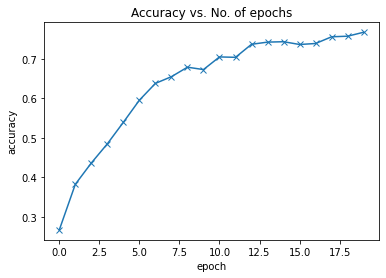

In [17]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(history)

In [18]:
def predict_image(image, model):
    xb = to_device(image.unsqueeze(0), device)  
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1) 
    return dataset.classes[preds[0].item()]

Label: anger , Predicted: anger


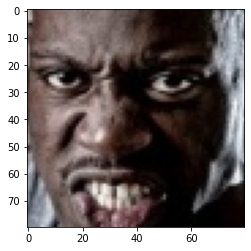

In [22]:
test_dataset = ImageFolder(datasetDir+'/test', transform=ToTensor())
image, label = test_dataset[69]
plt.imshow(image.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(image, model))


Label: anger , Predicted: happiness


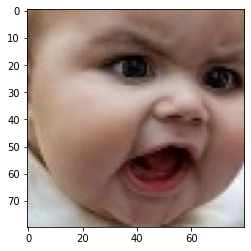

In [23]:
image, label = test_dataset[150]
plt.imshow(image.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(image, model))

## Testing accuracy of the model

In [24]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batchSize*2), device)
result = evaluate(model, test_loader)
print("test loss:",result['val_loss'])
print("test accuracy:",result['val_acc'])

test loss: 0.7600401639938354
test accuracy: 0.7944999933242798


In [25]:
torch.save(model.state_dict(),'mode.pth')

In [26]:
modelSaved = to_device(ATTModel(),device)
modelSaved.load_state_dict(torch.load('mode.pth'))

<All keys matched successfully>